# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [1]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from torch_geometric.data import Data
import torch
import torch.nn as nn
import dgl
from dgl.nn import GraphConv
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from sklearn.metrics.pairwise import cosine_similarity

from torch_geometric.nn import GCNConv

In [2]:
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])

test_set_final = pd.read_csv("../data/test_set_final.csv")
train_set_final = pd.read_csv("../data/train_set_final.csv")

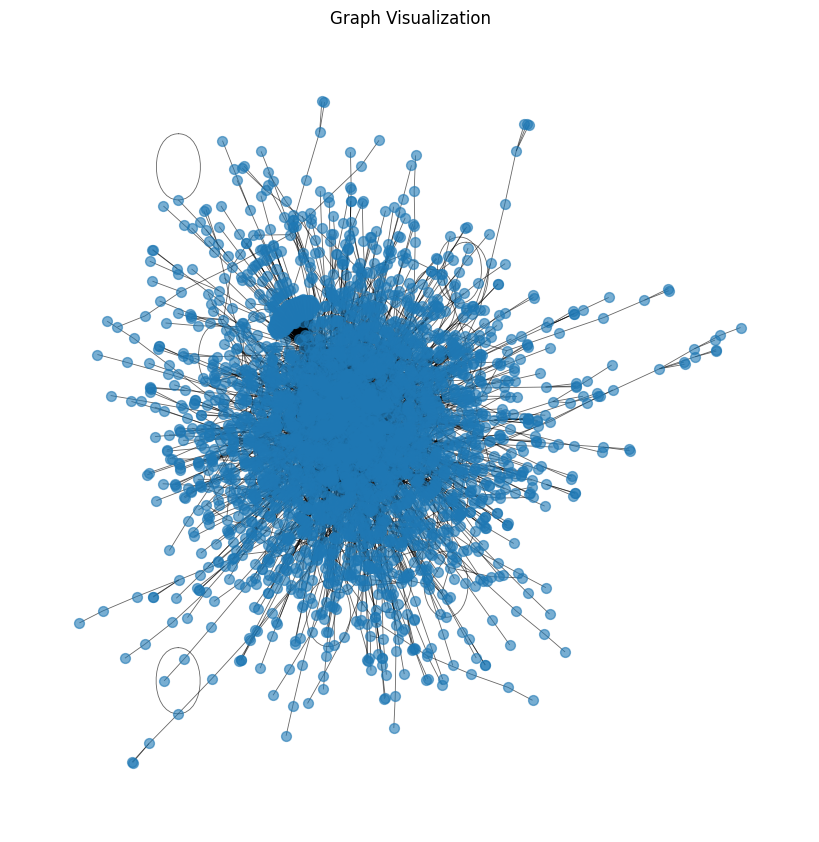

In [3]:
edges = train_set[train_set['label'] == 1][['source', 'target']].values.tolist()

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_size = 50, alpha = 0.6, width = 0.6)
plt.title("Graph Visualization")
plt.show()

## III - Data Modelling

In [4]:
from gensim.models import Word2Vec
from node2vec import Node2Vec

In [5]:
for node_id, attributes in node_info.iterrows():
    # Convert row to dictionary of features, excluding the node ID if it's not part of the attributes
    attr_dict = attributes.to_dict()
    # Update or add node with attributes if it doesn't exist
    if G.has_node(node_id):
        for key, value in attr_dict.items():
            G.nodes[node_id][key] = value

In [6]:
node2vec = Node2Vec(G, dimensions=128, walk_length=80, num_walks=10, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4) 

Computing transition probabilities:   0%|          | 0/3597 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


In [7]:
from sklearn.model_selection import train_test_split

def get_feature_vector(model, node1, node2):
    return np.multiply(model.wv[str(node1)], model.wv[str(node2)])  

features = []
labels = []
for index, row in train_set.iterrows():
    source = row['source']
    target = row['target']
    label = row['label']
    if str(source) in model.wv and str(target) in model.wv:
        features.append(get_feature_vector(model, source, target))
        labels.append(label)

features = np.array(features)
labels = np.array(labels)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.05, random_state=42)

# Step 4: Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

predictions = clf.predict_proba(X_test)[:, 1]  # Get probability estimates
auc_score = roc_auc_score(y_test, predictions)
print(f"AUC Score: {auc_score}")

AUC Score: 0.9914035087719298


In [8]:
features_test = []
for index, row in test_set.iterrows():
    source = row['source']
    target = row['target']
    if str(source) in model.wv and str(target) in model.wv:
        features_test.append(get_feature_vector(model, source, target))
        
X_test_fin = np.array(features_test)

predictions_lab = clf.predict(X_test_fin)

In [ ]:
ids_test = range(0, len(predictions_lab))

# Create a DataFrame with the IDs and predictions
predictions_df = pd.DataFrame({
    "ID": ids_test,
    "Predicted": predictions_lab
})

# Export the DataFrame to a CSV file
predictions_df.to_csv('../submission/Node2Vec/n2v_predictions.csv', index=False)